In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

hexes = gpd.read_file('../data/shapefiles/nyc/population_hexbinned.geojson')
boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')\
           .to_crs(hexes.crs)
tz    = gpd.read_file('../data/shapefiles/nyc/taxi_zones.geojson')\
           .to_crs(hexes.crs)
rides = pd.read_csv('../data/tables/fhv19.csv')

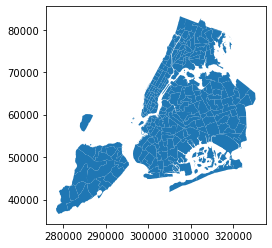

In [12]:
tz.plot();

In [62]:
rides['month']  = rides.apply(lambda row: row['time'].split('/')[0], axis=1)
rides['day']    = rides.apply(lambda row: row['time'].split('/')[1], axis=1)
rides['night?'] = rides.apply(lambda row: 0 if row['timegroupstr'] == 'daytime' else 1, axis=1)

sel_columns = ['']
rides

,Unnamed: 0,map,map2,inflow_counts,outflow_counts,loop_counts,time,taxizoneID,hour,weekday,week,timegroup,timegroupstr,month,day,night?
0,0,"('2019-01-01 00:00:00', '1')","('2019-01-01 00', '1')",5,6,0,1/1/19 0:00,1,0,Tuesday,1,2,12am - 4am,1,1,1
1,1,"('2019-01-01 00:00:00', '2')","('2019-01-01 00', '2')",0,0,0,1/1/19 0:00,2,0,Tuesday,1,2,12am - 4am,1,1,1
2,2,"('2019-01-01 00:00:00', '3')","('2019-01-01 00', '3')",46,66,4,1/1/19 0:00,3,0,Tuesday,1,2,12am - 4am,1,1,1
3,3,"('2019-01-01 00:00:00', '4')","('2019-01-01 00', '4')",116,240,7,1/1/19 0:00,4,0,Tuesday,1,2,12am - 4am,1,1,1
4,4,"('2019-01-01 00:00:00', '5')","('2019-01-01 00', '5')",14,16,4,1/1/19 0:00,5,0,Tuesday,1,2,12am - 4am,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757698,757698,"('2019-05-01 00:00:00', '259')","('2019-05-01 00', '259')",19,0,0,5/1/19 0:00,259,0,Wednesday,18,2,12am - 4am,5,1,1
757699,757699,"('2019-05-01 00:00:00', '260')","('2019-05-01 00', '260')",30,0,0,5/1/19 0:00,260,0,Wednesday,18,2,12am - 4am,5,1,1
757700,757700,"('2019-05-01 00:00:00', '261')","('2019-05-01 00', '261')",18,0,0,5/1/19 0:00,261,0,Wednesday,18,2,12am - 4am,5,1,1
757701,757701,"('2019-05-01 00:00:00', '262')","('2019-05-01 00', '262')",30,0,0,5/1/19 0:00,262,0,Wednesday,18,2,12am - 4am,5,1,1


In [31]:
for idx, row in rides[:10].iterrows():
    print(f"IDX: {row['map']}", f"TZ: {row['taxizoneID']}")

IDX: ('2019-01-01 00:00:00', '1') TZ: 1
IDX: ('2019-01-01 00:00:00', '2') TZ: 2
IDX: ('2019-01-01 00:00:00', '3') TZ: 3
IDX: ('2019-01-01 00:00:00', '4') TZ: 4
IDX: ('2019-01-01 00:00:00', '5') TZ: 5
IDX: ('2019-01-01 00:00:00', '6') TZ: 6
IDX: ('2019-01-01 00:00:00', '7') TZ: 7
IDX: ('2019-01-01 00:00:00', '8') TZ: 8
IDX: ('2019-01-01 00:00:00', '9') TZ: 9
IDX: ('2019-01-01 00:00:00', '10') TZ: 10


In [37]:
tz

,shape_area,objectid,shape_leng,location_id,zone,borough,geometry
0,0.0007823067885,1,0.116357453189,1,Newark Airport,EWR,"MULTIPOLYGON (((284409.729 58685.116, 284406.7..."
1,0.00486634037837,2,0.43346966679,2,Jamaica Bay,Queens,"MULTIPOLYGON (((314941.095 52464.112, 314993.0..."
2,0.000314414156821,3,0.0843411059012,3,Allerton/Pelham Gardens,Bronx,"MULTIPOLYGON (((312819.539 78262.951, 312876.4..."
3,0.000111871946192,4,0.0435665270921,4,Alphabet City,Manhattan,"MULTIPOLYGON (((302384.597 62092.175, 302383.1..."
4,0.000497957489363,5,0.0921464898574,5,Arden Heights,Staten Island,"MULTIPOLYGON (((285245.612 43977.649, 285307.5..."
...,...,...,...,...,...,...,...
258,0.000168611097013,256,0.0679149669603,256,Williamsburg (South Side),Brooklyn,"MULTIPOLYGON (((303520.032 60702.861, 303649.5..."
259,0.000394552487366,259,0.126750305191,259,Woodlawn/Wakefield,Bronx,"MULTIPOLYGON (((312547.051 82596.740, 312462.8..."
260,0.000422345326907,260,0.133514154636,260,Woodside,Queens,"MULTIPOLYGON (((308295.748 65978.056, 308319.8..."
261,0.0000343423231652,261,0.0271204563616,261,World Trade Center,Manhattan,"MULTIPOLYGON (((298873.824 59783.130, 298878.5..."
